In [11]:
%load_ext autoreload
%autoreload 2

In [19]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
from synbio_morpher.utils.results.analytics.timeseries import compute_step_response_times

# fn = 'data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
# dir_s = 'data/simulate_circuits/2025_02_01__00_22_38'
dir_s = 'data/simulate_circuits/2025_02_11__13_56_51'
# fn = 'data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json'

# d = pd.read_json(fn)

ts = np.load(os.path.join(dir_s, 'ts.npy'))
ys = np.load(os.path.join(dir_s, 'ys.npy'))
config = load_json_as_dict(os.path.join(dir_s, 'config.json'))
analytics = load_json_as_dict(os.path.join(dir_s, 'analytics.json'))
analytics['steady_states'] = np.array(analytics['steady_states'])


In [20]:
data = load_json_as_dict(os.path.join(dir_s, 'tabulated_mutation_info.json'))


In [21]:
import jax
from functools import partial
t_end = len(ts)
idx_c = 12
f_resp = jax.vmap(partial(compute_step_response_times, signal_time=ts[0], t=ts[:t_end]))
r = f_resp(data=np.swapaxes(ys[:, :t_end], -1, -2), steady_states=analytics['steady_states'][..., None])



<Axes: xlabel='response_time', ylabel='Count'>

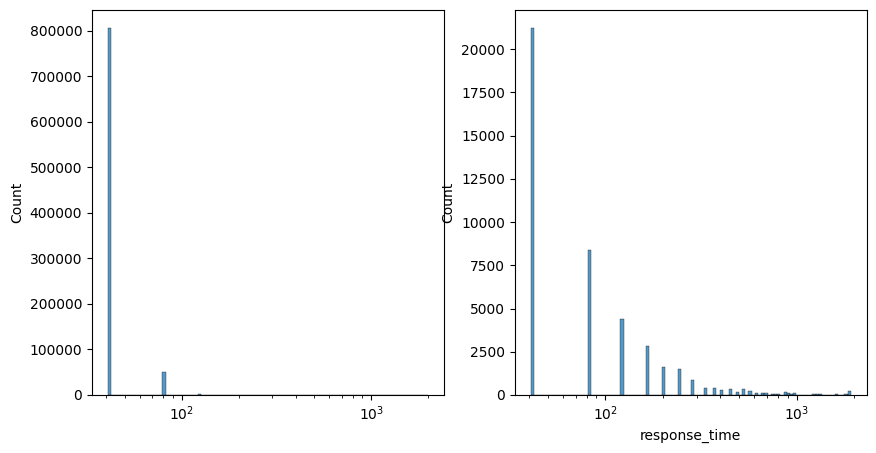

In [22]:
# nshow = int(2e4)
# plt.plot((ts * np.ones_like(ys[:nshow, :, -2])).T, ys[:nshow, :, -2].T, alpha=0.05, color='b')
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
sns.histplot(r[:, -1], log_scale=True, bins=100)
ax = plt.subplot(1, 2, 2)
sns.histplot(data, x='response_time', log_scale=True, bins=100)

In [2]:

from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
import pandas as pd
# fn = 'data/simulate_circuits/2025_01_28__21_36_14/analytics.json'
# fn = 'data/simulate_circuits/2025_01_29__14_52_44/analytics.json'
# fn = 'data/simulate_circuits/2025_01_29__18_12_38/analytics.json'
# fn = 'data/simulate_circuits/2025_02_01__00_22_38/analytics.json'
# fn = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
# fn = 'data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json'
# fn = 'data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json'
# fn = 'data/simulate_circuits/2025_02_11__13_56_51/analytics.json'
# fn = 'data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
fn = 'data/07_ruggedness/2025_02_07__15_33_55/analytics.json'

rn = {'sensitivity_wrt_species-6': 'sensitivity',
      'precision_wrt_species-6': 'precision',
      'response_time_wrt_species-6': 'response_time'}

if 'analytics' in fn:
    d = load_json_as_dict(fn)
    for k, v in rn.items():
        if k in d:
            print('renaming', k, 'to', v)
            d[v] = d.pop(k)
else:
    d = pd.read_json(fn) if fn.endswith('json') else pd.read_csv(fn)
    for k, v in rn.items():
        if k in d.columns:
            print('renaming', k, 'to', v)
            d.rename(columns={k: v}, inplace=True)
# write_json(d, fn)
# d.keys()
d.columns


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f83234bbe20>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


renaming sensitivity_wrt_species-6 to sensitivity
renaming precision_wrt_species-6 to precision
renaming response_time_wrt_species-6 to response_time


AttributeError: 'dict' object has no attribute 'columns'

In [2]:
write_json(d, fn)


In [ ]:
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd

def calculate_cross_category_mi(data, categories, n_bins=10):
    """
    Calculate mutual information between different categories of gene circuit components.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame where rows are different circuits and columns are component properties
    categories : dict
        Dictionary mapping category names to lists of column names
    n_bins : int
        Number of bins for discretizing continuous variables
    
    Returns:
    --------
    dict
        Dictionary containing MI matrices for each category pair
    """
    
    def _discretize_data(df, cols, n_bins):
        """Helper function to discretize continuous data"""
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
        df_disc = df.copy()
        for col in cols:
            if df[col].dtype in [np.float64, np.int64]:
                df_disc[col] = discretizer.fit_transform(df[col].values.reshape(-1, 1))
        return df_disc
    
    def _calculate_mi(x, y):
        """Calculate mutual information between two discrete variables"""
        # Calculate joint probability distribution
        joint_dist = np.histogram2d(x, y, bins=[np.unique(x).size, np.unique(y).size])[0]
        joint_dist = joint_dist / joint_dist.sum()
        
        # Calculate marginal distributions
        px = joint_dist.sum(axis=1)
        py = joint_dist.sum(axis=0)
        
        # Calculate entropies
        hx = entropy(px)
        hy = entropy(py)
        hxy = entropy(joint_dist.flatten())
        
        # Calculate mutual information
        mi = hx + hy - hxy
        return mi

    # Discretize all continuous variables
    data_disc = _discretize_data(data, data.columns, n_bins)
    
    # Calculate MI between all category pairs
    mi_results = {}
    for cat1 in categories:
        for cat2 in categories:
            if cat1 < cat2:  # Only calculate upper triangle
                mi_matrix = np.zeros((len(categories[cat1]), len(categories[cat2])))
                for i, col1 in enumerate(categories[cat1]):
                    for j, col2 in enumerate(categories[cat2]):
                        mi_matrix[i, j] = _calculate_mi(
                            data_disc[col1].values,
                            data_disc[col2].values
                        )
                mi_results[f"{cat1}_vs_{cat2}"] = {
                    'matrix': mi_matrix,
                    'rows': categories[cat1],
                    'cols': categories[cat2]
                }
    
    return mi_results

def plot_mi_heatmap(mi_results, category_pair):
    """
    Plot heatmap of mutual information between two categories.
    
    Parameters:
    -----------
    mi_results : dict
        Output from calculate_cross_category_mi
    category_pair : str
        Key from mi_results to plot (e.g., "promoters_vs_terminators")
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    result = mi_results[category_pair]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        result['matrix'],
        xticklabels=result['cols'],
        yticklabels=result['rows'],
        cmap='viridis',
        annot=True,
        fmt='.2f'
    )
    plt.title(f'Mutual Information: {category_pair}')
    plt.tight_layout()
    return plt

# Example usage:
if __name__ == "__main__":
    # Example data structure
    data = pd.DataFrame({
        'promoter_strength': np.random.random(100),
        'promoter_leakiness': np.random.random(100),
        'rbs_strength': np.random.random(100),
        'rbs_efficiency': np.random.random(100),
        'terminator_efficiency': np.random.random(100),
        'protein_stability': np.random.random(100)
    })
    
    # Define categories
    categories = {
        'promoters': ['promoter_strength', 'promoter_leakiness'],
        'rbs': ['rbs_strength', 'rbs_efficiency'],
        'output': ['terminator_efficiency', 'protein_stability']
    }
    
    # Calculate MI
    mi_results = calculate_cross_category_mi(data, categories)
    
    # Plot results
    plot_mi_heatmap(mi_results, 'promoters_vs_rbs')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Create figure
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Left Panel: Microscopic System
axs[0].plot(np.sin(np.linspace(0, 10, 100)), label='Component 1', color='black')
axs[0].plot(np.cos(np.linspace(0, 10, 100)), label='Component 2', color='black')
axs[0].arrow(50, 0.5, 10, 0, head_width=0.1, head_length=5, fc='blue', ec='blue')
axs[0].arrow(70, -0.5, -10, 0, head_width=0.1, head_length=5, fc='green', ec='green')
axs[0].set_title("Microscopic View")
axs[0].axis('off')

# Middle Panel: Network Representation
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 2), (2, 0), (2, 3)])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=['pink', 'blue', 'green', 'purple'], ax=axs[1], edge_color='black')
axs[1].set_title("Abstracted Network")

# Right Panel: Dynamics Plot
t = np.linspace(0, 10, 100)
axs[2].plot(t, np.tanh(t - 5), label='Variable 1', color='purple')
axs[2].plot(t, -np.tanh(t - 5), label='Variable 2', color='blue')
axs[2].plot(t, 0.1 * np.sin(t), label='Variable 3', color='green')
axs[2].axvline(5, linestyle='dashed', color='gray')
axs[2].legend()
axs[2].set_title("Macroscopic Dynamics")

plt.tight_layout()
plt.show()


# New Figure: Curved Arrows for Three Nodes
fig, ax = plt.subplots(figsize=(4, 4))
G = nx.DiGraph()
edges = [("RNA 1", "RNA 2"), ("RNA 2", "RNA 3"), ("RNA 3", "RNA 1"), ("RNA 2", "RNA 1"), ("RNA 3", "RNA 2"), ("RNA 1", "RNA 3")]
G.add_edges_from(edges)
for node in G.nodes():
    G.add_edge(node, node)
pos = {"RNA 1": (0, 1), "RNA 2": (-1, 0), "RNA 3": (1, 0)}

# Assign the same opacity for each pair of edges between the same nodes
edge_opacity = {}
opacities = [0.2, 0.6, 1.0]
opacities_iter = iter(opacities)
for u, v in edges:
    if (v, u) in edge_opacity:
        edge_opacity[(u, v)] = edge_opacity[(v, u)]
    else:
        edge_opacity[(u, v)] = next(opacities_iter)

edge_colors = [(0, 0, 0, edge_opacity[edge]) for edge in edges]
nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_color='lightgreen', edge_color=edge_colors, arrows=True, connectionstyle='arc3,rad=0.2', ax=ax, node_size=2000, node_shape='o')
ax.set_title("Curved Arrows Between Nodes with Paired Opacity")
plt.tight_layout()
plt.show()


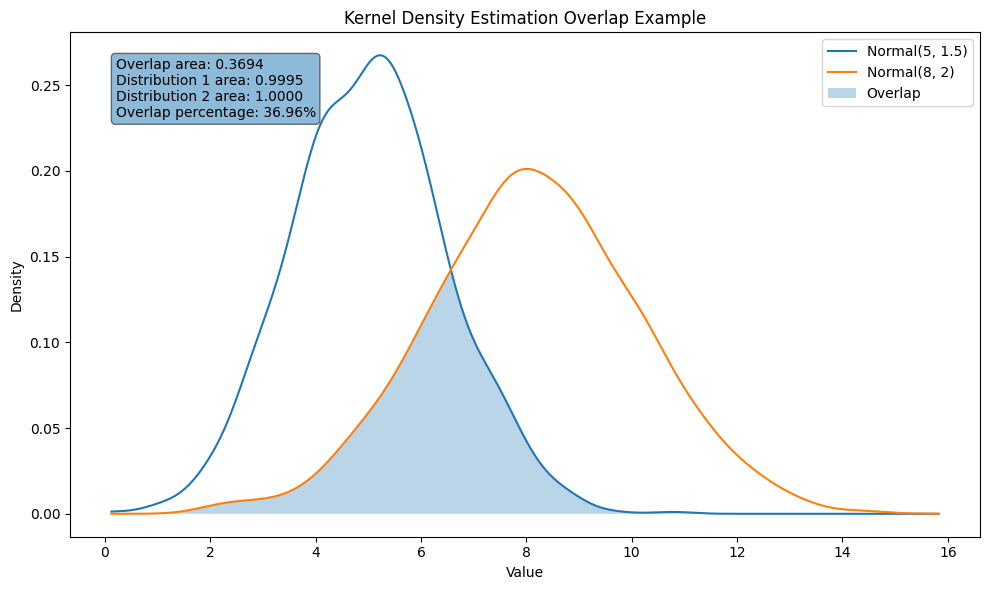

Overlap area: 0.3694
Overlap percentage: 36.96%


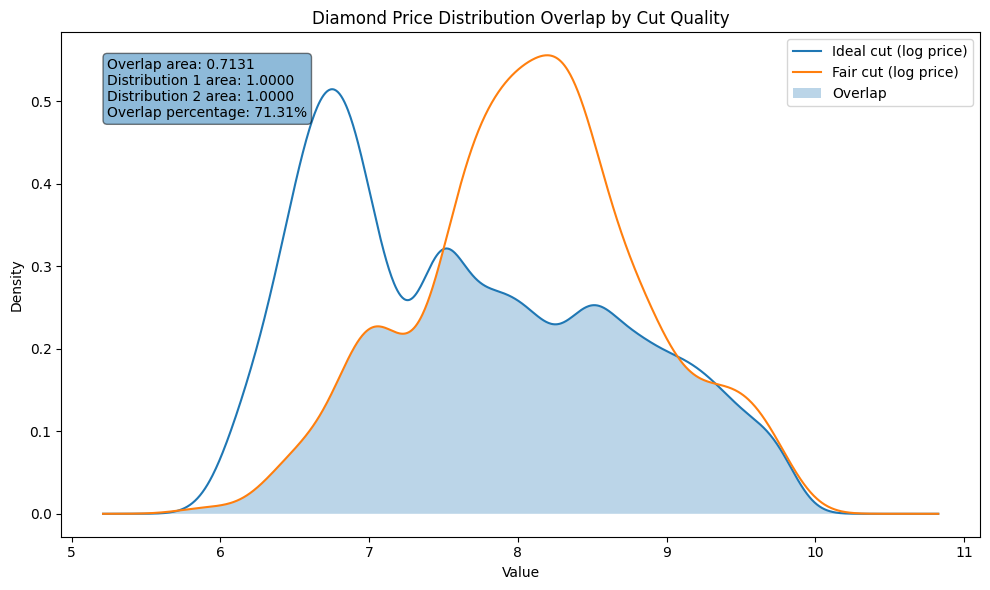


Diamond dataset example:
Overlap area between Ideal and Fair cut log prices: 0.7131
Overlap percentage: 71.31%


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def calculate_kde_overlap(sample1, sample2, bw_method=None, x_min=None, x_max=None, num_points=1000):
    """
    Calculate the overlapping area between two distributions using KDE.
    
    Parameters:
    -----------
    sample1, sample2 : array-like
        Sample data from the two distributions
    bw_method : str, scalar or callable, optional
        The method used to calculate the bandwidth, passed to scipy.stats.gaussian_kde
    x_min, x_max : float, optional
        The range over which to evaluate the KDEs. If None, determined from data.
    num_points : int, optional
        Number of points at which to evaluate the KDEs
        
    Returns:
    --------
    overlap : float
        The overlapping area between the two KDEs
    kde1_area, kde2_area : float
        The total areas under each KDE curve
    kde1, kde2 : scipy.stats.gaussian_kde objects
        The KDE objects for each distribution
    x : array
        The points at which the KDEs were evaluated
    """
    # Create the KDE objects
    kde1 = stats.gaussian_kde(sample1, bw_method=bw_method)
    kde2 = stats.gaussian_kde(sample2, bw_method=bw_method)
    
    # Determine the range to evaluate the KDEs
    if x_min is None:
        x_min = min(np.min(sample1), np.min(sample2))
        x_min = x_min - 0.1 * abs(x_min)  # Add some padding
    
    if x_max is None:
        x_max = max(np.max(sample1), np.max(sample2))
        x_max = x_max + 0.1 * abs(x_max)  # Add some padding
    
    # Create the evaluation points
    x = np.linspace(x_min, x_max, num_points)
    
    # Evaluate the KDEs at these points
    kde1_values = kde1(x)
    kde2_values = kde2(x)
    
    # Calculate the step size for numerical integration
    step = (x_max - x_min) / (num_points - 1)
    
    # Calculate the overlap by numerical integration of min(kde1, kde2)
    overlap_values = np.minimum(kde1_values, kde2_values)
    overlap = np.sum(overlap_values) * step
    
    # Calculate total areas (should be close to 1 for proper PDFs)
    kde1_area = np.sum(kde1_values) * step
    kde2_area = np.sum(kde2_values) * step
    
    return overlap, kde1_area, kde2_area, kde1, kde2, x

def plot_kde_overlap(sample1, sample2, labels=None, title=None, figsize=(10, 6), bw_method=None):
    """
    Plot two KDEs and their overlap, and return the overlap statistics.
    
    Parameters:
    -----------
    sample1, sample2 : array-like
        Sample data from the two distributions
    labels : list of str, optional
        Labels for the two distributions
    title : str, optional
        Title for the plot
    figsize : tuple, optional
        Figure size
    bw_method : str, scalar or callable, optional
        The method used to calculate the bandwidth
        
    Returns:
    --------
    overlap : float
        The overlapping area between the two KDEs
    overlap_percentage : float
        The overlap as a percentage of the smaller distribution area
    """
    if labels is None:
        labels = ['Distribution 1', 'Distribution 2']
    
    overlap, kde1_area, kde2_area, kde1, kde2, x = calculate_kde_overlap(
        sample1, sample2, bw_method=bw_method
    )
    
    # Calculate the overlap as a percentage of the smaller distribution
    overlap_percentage = (overlap / min(kde1_area, kde2_area)) * 100
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the KDEs
    kde1_values = kde1(x)
    kde2_values = kde2(x)
    overlap_values = np.minimum(kde1_values, kde2_values)
    
    ax.plot(x, kde1_values, label=labels[0])
    ax.plot(x, kde2_values, label=labels[1])
    ax.fill_between(x, 0, overlap_values, alpha=0.3, label='Overlap')
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'KDE Overlap: {overlap:.4f} ({overlap_percentage:.2f}%)')
    
    ax.legend()
    
    # Add a text box with the overlap statistics
    textstr = (
        f'Overlap area: {overlap:.4f}\n'
        f'Distribution 1 area: {kde1_area:.4f}\n'
        f'Distribution 2 area: {kde2_area:.4f}\n'
        f'Overlap percentage: {overlap_percentage:.2f}%'
    )
    props = dict(boxstyle='round', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return overlap, overlap_percentage

# Example usage
if __name__ == "__main__":
    # Generate some sample data
    np.random.seed(42)
    sample1 = np.random.normal(loc=5, scale=1.5, size=1000)
    sample2 = np.random.normal(loc=8, scale=2, size=1000)
    
    # Plot and calculate overlap
    overlap, overlap_percentage = plot_kde_overlap(
        sample1, sample2, 
        labels=['Normal(5, 1.5)', 'Normal(8, 2)'],
        title='Kernel Density Estimation Overlap Example'
    )
    
    print(f"Overlap area: {overlap:.4f}")
    print(f"Overlap percentage: {overlap_percentage:.2f}%")
    
    # Example with real data using seaborn datasets
    try:
        import seaborn as sns
        diamonds = sns.load_dataset('diamonds')
        
        # Compare price distributions for different diamond cuts
        ideal = diamonds[diamonds['cut'] == 'Ideal']['price']
        fair = diamonds[diamonds['cut'] == 'Fair']['price']
        
        # Log transform to handle the skewed price distribution
        ideal_log = np.log1p(ideal)
        fair_log = np.log1p(fair)
        
        overlap, overlap_percentage = plot_kde_overlap(
            ideal_log, fair_log,
            labels=['Ideal cut (log price)', 'Fair cut (log price)'],
            title='Diamond Price Distribution Overlap by Cut Quality'
        )
        
        print(f"\nDiamond dataset example:")
        print(f"Overlap area between Ideal and Fair cut log prices: {overlap:.4f}")
        print(f"Overlap percentage: {overlap_percentage:.2f}%")
    except:
        print("Seaborn diamond dataset example couldn't be loaded")

In [1]:
from evoscaper.utils.simulation import setup_model, make_rates, prep_sim, sim, prep_cfg
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from evoscaper.utils.math import make_batch_symmetrical_matrices, make_sequence_from_symmetrical
import pandas as pd
import numpy as np
import seaborn as sns

fn = f'./data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
data = pd.read_json(fn)
x_type = 'energies'
config_bio = load_json_as_dict(f'./data/simulate_circuits/2025_02_11__13_56_51/config.json')


xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


<Axes: ylabel='Count'>

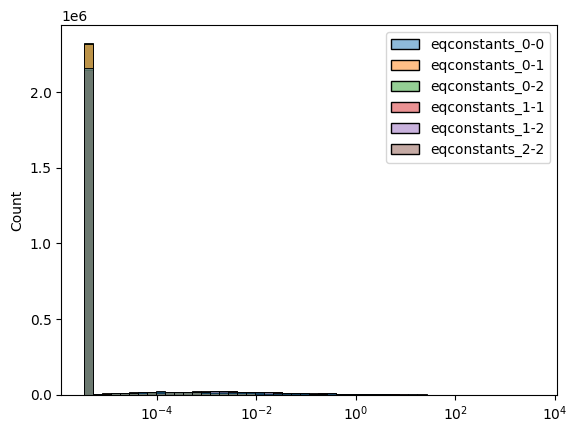

In [ ]:
input_species = data[data['sample_name'].notna()]['sample_name'].unique()
num_species = len(input_species)
fake_circuits = data[get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].values

fake_circuits_reshaped = make_batch_symmetrical_matrices(
    fake_circuits.reshape(-1, fake_circuits.shape[-1]), side_length=len(input_species))

model_brn, qreactions, ordered_species, postprocs = setup_model(
    fake_circuits_reshaped, config_bio, input_species, x_type)

if x_type == 'energies':
    eqconstants, (forward_rates, reverse_rates) = postprocs[x_type](
        fake_circuits_reshaped)
elif x_type == 'eqconstants':
    forward_rates, reverse_rates = postprocs[x_type](
        fake_circuits_reshaped)
elif x_type == 'binding_rates_dissociation':
    # reverse_rates = fake_circuits_reshaped
    # eqconstants = forward_rates[0, 0, 0] / reverse_rates
    forward_rates, reverse_rates = postprocs[x_type](
        fake_circuits_reshaped)
    
eqconstants_flat = make_sequence_from_symmetrical(eqconstants, num_species)
reverse_rates_flat = make_sequence_from_symmetrical(reverse_rates, num_species)

num_species = len(input_species)
a = np.triu(np.ones((num_species, num_species)))
names_eq = list(map(lambda i: 'eqconstants' + '_' + str(i[0]) + '-' + str(i[1]), np.array(np.where(a > 0)).T))
names_rt = list(map(lambda i: 'binding_rates_dissociation' + '_' + str(i[0]) + '-' + str(i[1]), np.array(np.where(a > 0)).T))
    
data[names_eq] = eqconstants_flat
data[names_rt] = reverse_rates_flat

sns.histplot(data[names_eq], bins=50, log_scale=[False, True])

In [ ]:
# write_json(data, fn)